In [ ]:
# Do we have enough tracks here? Or will we get push back?
# Need some statistical significance on the profiles
# How many tracks can we actually get in the Weddell? How much of a subset is this?
# Can we plot these tracks on to a Weddell map, to get a sense of their spatial distributions?

In [10]:
import os
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
import time


In [11]:
# Functions 

def dist(lon1,lat1,lon2,lat2):
  lon1_rad = np.radians(lon1)
  lon2_rad = np.radians(lon2)
  lat1_rad = np.radians(lat1)
  lat2_rad = np.radians(lat2)
  #Assumes degrees input
  #Calculates in metres
  R = 6371000 #Radius of earth in metres (roughly)
  ## Uses Haversine formula
  a1 = (sin((lat2_rad-lat1_rad)/2))**2
  a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
  a = a1 + a2
  c = 2*atan2(sqrt(a),sqrt(1-a))
  d = R*c
  return d

def get_floes(ice_leads_msk,fb_height,seg_dist_x,rprof):
    nfloes_max = int(np.floor(len(ice_leads_msk)/2)) # Estimated max number of floes (to make big enough arrays)
    floe_chord_lengths = np.zeros(nfloes_max) 
    floe_fb = np.zeros(nfloes_max) 
    floe_profiles = np.zeros((nprof,nfloes_max))
    ice_cnt_st = 0
    ice_cnt_en = 0
    floe_idx = 1
    for i in range(1,len(ice_leads_msk)):
        if (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 0): # start floe
            ice_cnt_st = i
            ice_cnt_en = i
        elif (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 1): # grow floe
            ice_cnt_en += 1
        elif (ice_leads_msk[i-1] == 1) and (ice_leads_msk[i] == 0): # stop floe
            floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
            #
            prof = fb_height[ice_cnt_st:ice_cnt_en+1]
            xx_prof = np.linspace(0,1,ice_cnt_en-ice_cnt_st+1)
            floe_profiles[:,floe_idx] = np.interp(rprof, xx_prof, prof)
            floe_idx += 1
    #        
    # Removing spurious floes (< 10m, > 10 km, fb < 0.1)
    remove_idx = np.where(floe_chord_lengths < 10)[0]  
    remove_idx = np.append(remove_idx,np.where(floe_chord_lengths > 10e3)[0])
    remove_idx = np.append(remove_idx,np.where(floe_fb < 0.1)[0])
    floe_fb = np.delete(floe_fb,remove_idx)
    floe_chord_lengths = np.delete(floe_chord_lengths,remove_idx)
    floe_profiles = np.delete(floe_profiles,remove_idx,axis=1)
    #
    return floe_chord_lengths, floe_fb, floe_profiles

def normalize_vector(v):
    vmin = np.amin(v)
    vmax = np.amax(v)
    return (v - vmin)  / (vmax - vmin)

def get_size_binned_profiles(floe_profiles,floe_chord_lengths):
    half_idx = int(np.shape(floe_profiles)[0]/2) # index of halfway point across the floe profile
    bin_ranges = [10, 100, 1000, 10000] # MG: BETTER TO DO 50, 500, 5000, 50000
    nbins = len(bin_ranges) - 1
    nr = np.shape(floe_profiles)[0]
    binned_profiles = np.zeros((nr,nbins))
    for i in range(nbins):
        idx1 = np.where( (floe_chord_lengths >= bin_ranges[i]) )[0]
        idx2 = np.where( (floe_chord_lengths < bin_ranges[i+1]) )[0] 
        idx = np.intersect1d(idx1, idx2)
        if idx.size != 0:
            fp = floe_profiles[:,idx]
            floe_profiles_norm = normalize_vector(fp)
            LHS = np.mean(floe_profiles_norm[0:half_idx],axis=1)
            RHS = np.mean(floe_profiles_norm[half_idx:],axis=1)
            full = normalize_vector(0.5*(LHS + np.flip(RHS))) 
            binned_profiles[:,i] = np.concatenate((full, np.flip(full)), axis=0) * np.mean(fp)
    return binned_profiles
    

ATL10-02_20210203133757_06351001_005_01.h5
ATL10-02_20191208090337_11070501_005_02.h5
ATL10-02_20191025090101_04350501_005_02.h5
ATL10-02_20190301114641_09630201_005_02.h5
ATL10-02_20211030132017_05821301_005_01.h5
ATL10-02_20190317111321_12070201_005_02.h5
ATL10-02_20211014135334_03381301_005_01.h5
ATL10-02_20210303110522_10611001_005_01.h5
ATL10-02_20191031093538_05270501_005_02.h5
ATL10-02_20191005125113_01320501_005_02.h5
ATL10-02_20190905113210_10600401_005_02.h5
ATL10-02_20211103100324_06411301_005_01.h5
ATL10-02_20191002105936_00850501_005_02.h5
ATL10-02_20191104092718_05880501_005_02.h5
ATL10-02_20191013123433_02540501_005_02.h5
ATL10-02_20211203112222_11001301_005_01.h5
ATL10-02_20211021105400_04431301_005_01.h5
ATL10-02_20191030100118_05120501_005_02.h5
ATL10-02_20211119110427_08861301_005_01.h5
ATL10-02_20210208130358_07111001_005_01.h5
ATL10-02_20211020111939_04281301_005_01.h5
ATL10-02_20211108110341_07181301_005_01.h5
ATL10-02_20191010104255_02070501_005_02.h5
ATL10-02_20

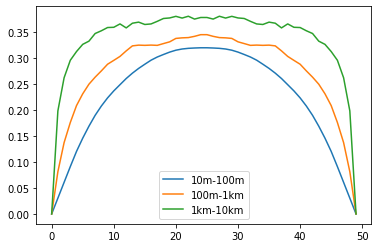

In [20]:
# Studying floe profiles

# MG: INCLUDE ERROR BARS ONTO FLOES CHORDS

path = 'data/ATL10/Weddell/'
filelist = [file for file in os.listdir(path) if file.endswith('.h5')]
nfiles = len(filelist)

# Initializing bin ranges
nn = 10
floe_chord_bin_ranges = []
for i in range(3):
    st = 10**(i+1)
    en = 10**(i+2) 
    stp = 2*10**(i)
    floe_chord_bin_ranges = np.append(floe_chord_bin_ranges,np.arange(st,en,stp))
floe_chord_bin_means = 0.5*(floe_chord_bin_ranges[0:-1] + floe_chord_bin_ranges[1:])
nbins_chords = len(floe_chord_bin_means)

# Floe profile parameters 
nprof = 50 # number of points in normalized profiles
rprof = np.linspace(0,1,nprof)

# # Looping through h5 files in directory
floe_chord_lengths = []
floe_fb = []
floe_profiles = []
cnt_file = 0
for fname in filelist:
    this_ATL10=h5py.File(path+fname, 'r')
    print(fname)
    
    # Getting strong beams 
    orient = this_ATL10['orbit_info/sc_orient'][0]
    if orient==0:
        strong_beams = ['gt1l','gt2l','gt3l']
    elif orient==1:
        strong_beams = ['gt1r','gt2r','gt3r']
    else:
        strong_beams = []
    
    # Looping over strong beams
    for beam in strong_beams:  
        # Getting data
        fb_height = np.array(np.squeeze(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/beam_fb_height'])) 
        fb_lat = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/latitude'])
        fb_lon = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/longitude'])
        height_segment_ssh_flag = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_ssh_flag'])
        seg_dist_x = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/seg_dist_x'])
        height_segment_type = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_type'])
        fb_height[fb_height > 30] = 0
        #
        beam_lead_n = this_ATL10[beam+'/freeboard_beam_segment/beam_lead_n']
        ref_height = this_ATL10[beam+'/freeboard_beam_segment/beam_refsurf_alongtrack_slope']
        ice_conc = this_ATL10[beam+'/freeboard_beam_segment/height_segments/ice_conc']
        lead_height = this_ATL10[beam+'/leads/lead_height']
        lead_length = this_ATL10[beam+'/leads/lead_length']
        lead_lat = this_ATL10[beam+'/leads/latitude']
        lead_lon = this_ATL10[beam+'/leads/longitude']

        # Making a mask for spurious values
        npoints = len(fb_height)
        spurious_msk = np.ones(npoints)
        spurious_msk[fb_height>1e38] = 0
        #
        delta_seg_dist_x = np.append(0,np.diff(seg_dist_x)) 
        spurious_msk[delta_seg_dist_x > 500] = 0
        # 
        spurious_msk[np.isnan(fb_height)] = 0
        #
        spurious_msk[fb_height<0.05] = 0

        # Creating binary array for: leads or spurious (0) / ice (1)
        ice_leads_msk = np.array(height_segment_type)
        ice_leads_msk[ice_leads_msk < 2] = 0
        ice_leads_msk[ice_leads_msk > 4] = 0
        ice_leads_msk[(ice_leads_msk <= 4)*(ice_leads_msk >= 2)] = 1
        ice_leads_msk = ice_leads_msk*spurious_msk
        ice_leads_msk = 1 - ice_leads_msk
        
        # Getting floes
        floe_chord_lengths_tmp, floe_fb_tmp, floe_profiles_tmp = get_floes(ice_leads_msk,fb_height,seg_dist_x,rprof)
        
        # Appending to across-beam vectors
        floe_chord_lengths = np.append(floe_chord_lengths,floe_chord_lengths_tmp)
        floe_fb = np.append(floe_fb,floe_fb_tmp)
        floe_profiles = np.append(floe_profiles,np.ndarray.flatten(floe_profiles_tmp,order='F'),axis=0)
#         print(np.shape(floe_profiles_tmp))
        
    cnt_file += 1

n1 = 50
n2 = int(len(floe_profiles)/n1)    
floe_profiles = np.transpose(np.reshape(floe_profiles,(n2,n1)) )      
 

binned_profiles = get_size_binned_profiles(floe_profiles,floe_chord_lengths)


plt.plot(binned_profiles)
plt.legend(['10m-100m', '100m-1km', '1km-10km'])
